In [7]:
#Loading datasets and importing libraries
!pip install contractions # Install library first
!pip install vaderSentiment
import numpy as np, pandas as pd, re, collections
import nltk, unicodedata, contractions, spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
tmp = nltk.download(['stopwords', 'averaged_perceptron_tagger', 'wordnet'], quiet=True) #load stopwords, averaged_perceptron_tagger, wordnet
LosStopWords = nltk.corpus.stopwords.words('english') #set up stopwords list
LosStopWords.append('might')
LosStopWords.append('would')
LosStopWords.append('could')
LosStopWords.append('I')
LosStopWords.append('A')
LosStopWords.append('n')
LosStopWords.append('must')
LosStopWords.append('shall')
LosStopWords.append('may')
LosStopWords.append('u')
nlp = spacy.load('en', disable=['parser', 'ner']) #use like lemmitazer
lemmatizer = nltk.stem.WordNetLemmatizer()
analyser = SentimentIntensityAnalyzer()

def letters_counter(_list_):
  #function for counting letters in words into tokens
  count = 0
  for item in _list_:
    count += len(item)
  return count

def stopwords_removal(_list_, stopwords_list):
  #function for removing stop words
  tmp_list = []
  for item in _list_:
    if not item in stopwords_list:
      tmp_list.append(item)
  return tmp_list

def remove_special_characters(text, keep_digits=True, keep_dots=True):
  #function for removing special_characters and changing "! ? ..." into "."
  clean_text = re.sub('[?!]', '\.', text)
  clean_text = re.sub('…', '\.', clean_text)
  clean_text = re.sub('\xa0', '', clean_text)
  if keep_digits == True and keep_dots == True:
    pattern = r'[^a-zA-Z0-9 \.]'
  elif keep_digits == False and keep_dots == True:
    pattern = r'[^a-zA-Z \.]'
  elif keep_digits == True and keep_dots == False:
    pattern = r'[^a-zA-Z0-9 ]'
  else:
    pattern = r'[^a-zA-Z ]'
  #pattern = r'[^\w\s]'    # respects unicode characters, digits, underscores
  clean_text = re.sub(pattern, repl='', string=clean_text)
  return clean_text

def resub_names(text):
  pattern = re.compile('[^!?\.] [A-Z][a-zA-Z]+\W')
  find = re.findall(pattern, text)
  not_removeable_words = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday',
                          'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December',
                          'God']
  for item in find:
    pattern_for_resub = item[2:-1]
    if not item in not_removeable_words:
      text = re.sub(pattern_for_resub,'',text)
  return text 

def cleanhtml(raw_html):
  #Removal of html and other tags (as necessary)
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  return cleantext

def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}
    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

#read books
with open('/content/drive/My Drive/Colab Notebooks/Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay.txt', 'r') as f1:
  BOOK_2000_EX_1 = f1.read()
with open('/content/drive/My Drive/Colab Notebooks/Crotchet_Castle_by_Thomas_Love_Peacock.txt', 'r') as f2:
  BOOK_1830_EX_2 = f2.read()
with open('/content/drive/My Drive/Colab Notebooks/Paul_Clifford_by_Edward_Bulwer-Lytton.txt', 'r') as f3:
  BOOK_1830_EX_1 = f3.read()
with open('/content/drive/My Drive/Colab Notebooks/jonathan_franzen_the_corrections.txt', 'r') as f4:
  BOOK_2000_EX_2 = f4.read()

#pre-processing pipeline for books: remove html and other tags => remove accents marks => expand constractions => remove people/companies and other names
# => remove special_characters => make a tokenization => remove stopwords => make a lemmitization
#book: Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay
BOOK_2000_EX_1v1 = cleanhtml(BOOK_2000_EX_1)
BOOK_2000_EX_1v2 = unicodedata.normalize('NFKD', BOOK_2000_EX_1v1).encode('utf-8', 'ignore').decode('utf-8', 'ignore')
BOOK_2000_EX_1v3 = contractions.fix(BOOK_2000_EX_1v2)
BOOK_2000_EX_1v4 = resub_names(BOOK_2000_EX_1v3) #1 out of 3 = 86% clean
BOOK_2000_EX_1v4 = resub_names(BOOK_2000_EX_1v4) #2 out of 3 = 99% clean
BOOK_2000_EX_1v4 = resub_names(BOOK_2000_EX_1v4) #3 out of 3 = 100% clean
BOOK_2000_EX_1v5 = remove_special_characters(BOOK_2000_EX_1v4, keep_dots=False)
BOOK_2000_EX_1v6 = nltk.WordPunctTokenizer().tokenize(BOOK_2000_EX_1v5)
BOOK_2000_EX_1v7 = stopwords_removal(BOOK_2000_EX_1v6, LosStopWords)
BOOK_2000_EX_1v8 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in BOOK_2000_EX_1v7]
#book: Crotchet_Castle_by_Thomas_Love_Peacock
BOOK_1830_EX_2v1 = cleanhtml(BOOK_1830_EX_2)
BOOK_1830_EX_2v2 = unicodedata.normalize('NFKD', BOOK_1830_EX_2v1).encode('utf-8', 'ignore').decode('utf-8', 'ignore')
BOOK_1830_EX_2v3 = contractions.fix(BOOK_1830_EX_2v2)
BOOK_1830_EX_2v4 = resub_names(BOOK_1830_EX_2v3) #1 out of 3 = 92% clean
BOOK_1830_EX_2v4 = resub_names(BOOK_1830_EX_2v4) #2 out of 3 = 99% clean
BOOK_1830_EX_2v4 = resub_names(BOOK_1830_EX_2v4) #3 out of 3 = 100% clean
BOOK_1830_EX_2v5 = remove_special_characters(BOOK_1830_EX_2v4, keep_dots=False)
BOOK_1830_EX_2v6 = nltk.WordPunctTokenizer().tokenize(BOOK_1830_EX_2v5)
BOOK_1830_EX_2v7 = stopwords_removal(BOOK_1830_EX_2v6, LosStopWords)
BOOK_1830_EX_2v8 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in BOOK_1830_EX_2v7]
#book: Paul_Clifford_by_Edward_Bulwer-Lytton
BOOK_1830_EX_1v1 = cleanhtml(BOOK_1830_EX_1)
BOOK_1830_EX_1v2 = unicodedata.normalize('NFKD', BOOK_1830_EX_1v1).encode('utf-8', 'ignore').decode('utf-8', 'ignore')
BOOK_1830_EX_1v3 = contractions.fix(BOOK_1830_EX_1v2)
BOOK_1830_EX_1v4 = resub_names(BOOK_1830_EX_1v3) #1 out of 4 = 89% clean
BOOK_1830_EX_1v4 = resub_names(BOOK_1830_EX_1v4) #2 out of 4 = 99% clean 
BOOK_1830_EX_1v4 = resub_names(BOOK_1830_EX_1v4) #3 out of 4 = 99% clean
BOOK_1830_EX_1v4 = resub_names(BOOK_1830_EX_1v4) #4 out of 4 = 100% clean
BOOK_1830_EX_1v5 = remove_special_characters(BOOK_1830_EX_1v4, keep_dots=False)
BOOK_1830_EX_1v6 = nltk.WordPunctTokenizer().tokenize(BOOK_1830_EX_1v5)
BOOK_1830_EX_1v7 = stopwords_removal(BOOK_1830_EX_1v6, LosStopWords)
BOOK_1830_EX_1v8 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in BOOK_1830_EX_1v7]
#book: jonathan_franzen_the_corrections
BOOK_2000_EX_2v1 = cleanhtml(BOOK_2000_EX_2)
BOOK_2000_EX_2v2 = unicodedata.normalize('NFKD', BOOK_2000_EX_2v1).encode('utf-8', 'ignore').decode('utf-8', 'ignore')
BOOK_2000_EX_2v3 = contractions.fix(BOOK_2000_EX_2v2)
BOOK_2000_EX_2v4 = resub_names(BOOK_2000_EX_2v3) #1 out of 3 = 82% clean
BOOK_2000_EX_2v4 = resub_names(BOOK_2000_EX_2v4) #2 out of 3 = 99% clean
BOOK_2000_EX_2v4 = resub_names(BOOK_2000_EX_2v4) #3 out of 3 = 100% clean
BOOK_2000_EX_2v5 = remove_special_characters(BOOK_2000_EX_2v4, keep_dots=False)
BOOK_2000_EX_2v6 = nltk.WordPunctTokenizer().tokenize(BOOK_2000_EX_2v5)
BOOK_2000_EX_2v7 = stopwords_removal(BOOK_2000_EX_2v6, LosStopWords)
BOOK_2000_EX_2v8 = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in BOOK_2000_EX_2v7]


     |████████████████████████████████| 133kB 8.8MB/s 


In [171]:
#preparation for sentense analysis
BOOK_2000_EX_1v5_2 = remove_special_characters(BOOK_2000_EX_1v3).split('.')
BOOK_1830_EX_2v5_2 = remove_special_characters(BOOK_1830_EX_2v3).split('.')
BOOK_1830_EX_1v5_2 = remove_special_characters(BOOK_1830_EX_1v3).split('.')
BOOK_2000_EX_2v5_2 = remove_special_characters(BOOK_2000_EX_2v3).split('.')

df_book1_sentences = pd.DataFrame(BOOK_2000_EX_1v5_2, columns=['sentence'])
df_book1_sentences['length'] = df_book1_sentences.sentence.str.len()
df_book1_sentences['words_count'] = df_book1_sentences.sentence.str.split().apply(len)
df_book1_sentences['book_name'] = 'Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay'
df_book1_sentences['year'] = 2000
df_book2_sentences = pd.DataFrame(BOOK_1830_EX_2v5_2, columns=['sentence'])
df_book2_sentences['length'] = df_book2_sentences.sentence.str.len()
df_book2_sentences['words_count'] = df_book2_sentences.sentence.str.split().apply(len)
df_book2_sentences['book_name'] = 'Crotchet_Castle_by_Thomas_Love_Peacock'
df_book2_sentences['year'] = 1830
df_book3_sentences = pd.DataFrame(BOOK_1830_EX_1v5_2, columns=['sentence'])
df_book3_sentences['length'] = df_book3_sentences.sentence.str.len()
df_book3_sentences['words_count'] = df_book3_sentences.sentence.str.split().apply(len)
df_book3_sentences['book_name'] = 'Paul_Clifford_by_Edward_Bulwer-Lytton'
df_book3_sentences['year'] = 1830
df_book4_sentences = pd.DataFrame(BOOK_2000_EX_2v5_2, columns=['sentence'])
df_book4_sentences['length'] = df_book4_sentences.sentence.str.len()
df_book4_sentences['words_count'] = df_book4_sentences.sentence.str.split().apply(len)
df_book4_sentences['book_name'] = 'jonathan_franzen_the_corrections'
df_book4_sentences['year'] = 2000

df_all_books_sentences = pd.concat([df_book1_sentences, df_book2_sentences, df_book3_sentences, df_book4_sentences])


In [172]:
#sentences analysis
print('\nthe longest sentence by letters:')
print(f'Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s) is {df_all_books_sentences.length.loc[df_all_books_sentences.book_name == "Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay"].max()}')
print(f'Crotchet_Castle_by_Thomas_Love_Peacock (1830s) is {df_all_books_sentences.length.loc[df_all_books_sentences.book_name == "Crotchet_Castle_by_Thomas_Love_Peacock"].max()}')
print(f'Paul_Clifford_by_Edward_Bulwer-Lytton (1830s) is {df_all_books_sentences.length.loc[df_all_books_sentences.book_name == "Paul_Clifford_by_Edward_Bulwer-Lytton"].max()}')
print(f'jonathan_franzen_the_corrections (2000s) is {df_all_books_sentences.length.loc[df_all_books_sentences.book_name == "jonathan_franzen_the_corrections"].max()}')
print(f'Both books (2000s) is {df_all_books_sentences.length.loc[df_all_books_sentences.year == 2000].max()}')
print(f'Both books (1830s) is {df_all_books_sentences.length.loc[df_all_books_sentences.year == 1830].max()}')

print('\nthe longest sentence by words:')
print(f'Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.book_name == "Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay"].max()}')
print(f'Crotchet_Castle_by_Thomas_Love_Peacock (1830s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.book_name == "Crotchet_Castle_by_Thomas_Love_Peacock"].max()}')
print(f'Paul_Clifford_by_Edward_Bulwer-Lytton (1830s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.book_name == "Paul_Clifford_by_Edward_Bulwer-Lytton"].max()}')
print(f'jonathan_franzen_the_corrections (2000s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.book_name == "jonathan_franzen_the_corrections"].max()}')
print(f'Both books (2000s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.year == 2000].max()}')
print(f'Both books (1830s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.year == 1830].max()}')

print('\nthe median sentence by letters:')
print(f'Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s) is {df_all_books_sentences.length.loc[df_all_books_sentences.book_name == "Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay"].median()}')
print(f'Crotchet_Castle_by_Thomas_Love_Peacock (1830s) is {df_all_books_sentences.length.loc[df_all_books_sentences.book_name == "Crotchet_Castle_by_Thomas_Love_Peacock"].median()}')
print(f'Paul_Clifford_by_Edward_Bulwer-Lytton (1830s) is {df_all_books_sentences.length.loc[df_all_books_sentences.book_name == "Paul_Clifford_by_Edward_Bulwer-Lytton"].median()}')
print(f'jonathan_franzen_the_corrections (2000s) is {df_all_books_sentences.length.loc[df_all_books_sentences.book_name == "jonathan_franzen_the_corrections"].median()}')
print(f'Both books (2000s) is {df_all_books_sentences.length.loc[df_all_books_sentences.year == 2000].median()}')
print(f'Both books (1830s) is {df_all_books_sentences.length.loc[df_all_books_sentences.year == 1830].median()}')

print('\nthe median sentence by words:')
print(f'Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.book_name == "Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay"].median()}')
print(f'Crotchet_Castle_by_Thomas_Love_Peacock (1830s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.book_name == "Crotchet_Castle_by_Thomas_Love_Peacock"].median()}')
print(f'Paul_Clifford_by_Edward_Bulwer-Lytton (1830s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.book_name == "Paul_Clifford_by_Edward_Bulwer-Lytton"].median()}')
print(f'jonathan_franzen_the_corrections (2000s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.book_name == "jonathan_franzen_the_corrections"].median()}')
print(f'Both books (2000s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.year == 2000].median()}')
print(f'Both books (1830s) is {df_all_books_sentences.words_count.loc[df_all_books_sentences.year == 1830].median()}')


the longest sentence by letters:
Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s) is 842
Crotchet_Castle_by_Thomas_Love_Peacock (1830s) is 969
Paul_Clifford_by_Edward_Bulwer-Lytton (1830s) is 1254
jonathan_franzen_the_corrections (2000s) is 1966
Both books (2000s) is 1966
Both books (1830s) is 1254

the longest sentence by words:
Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s) is 149
Crotchet_Castle_by_Thomas_Love_Peacock (1830s) is 174
Paul_Clifford_by_Edward_Bulwer-Lytton (1830s) is 211
jonathan_franzen_the_corrections (2000s) is 354
Both books (2000s) is 354
Both books (1830s) is 211

the median sentence by letters:
Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s) is 46.0
Crotchet_Castle_by_Thomas_Love_Peacock (1830s) is 31.0
Paul_Clifford_by_Edward_Bulwer-Lytton (1830s) is 84.0
jonathan_franzen_the_corrections (2000s) is 52.0
Both books (2000s) is 47.0
Both books (1830s) is 70.0

the median sentence by words:
Chabon_Michael_The Amazing_Ad

In [173]:
#words analysis
print('Book1 - Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s)')
print('Book2 - Crotchet_Castle_by_Thomas_Love_Peacock (1830s)')
print('Book3 - Paul_Clifford_by_Edward_Bulwer-Lytton (1830s))')
print('Book4 - jonathan_franzen_the_corrections (2000s)')
print(f'Intersection of Book1 and Book2 is {len(set(BOOK_2000_EX_1v8).intersection(set(BOOK_1830_EX_2v8)))} or {round(len(set(BOOK_2000_EX_1v8).intersection(set(BOOK_1830_EX_2v8)))/len(set(BOOK_2000_EX_1v8))*100,1)}% of Book1')
print(f'Intersection of Book1 and Book3 is {len(set(BOOK_2000_EX_1v8).intersection(set(BOOK_1830_EX_1v8)))} or {round(len(set(BOOK_2000_EX_1v8).intersection(set(BOOK_1830_EX_1v8)))/len(set(BOOK_2000_EX_1v8))*100,1)}% of Book1')
print(f'Intersection of Book1 and Book4 is {len(set(BOOK_2000_EX_1v8).intersection(set(BOOK_2000_EX_2v8)))} or {round(len(set(BOOK_2000_EX_1v8).intersection(set(BOOK_2000_EX_2v8)))/len(set(BOOK_2000_EX_1v8))*100,1)}% of Book1')
print(f'Intersection of Book2 and Book3 is {len(set(BOOK_1830_EX_2v8).intersection(set(BOOK_1830_EX_1v8)))} or {round(len(set(BOOK_1830_EX_2v8).intersection(set(BOOK_1830_EX_1v8)))/len(set(BOOK_1830_EX_2v8))*100,1)}% of Book2')
print(f'Intersection of Book2 and Book4 is {len(set(BOOK_1830_EX_2v8).intersection(set(BOOK_2000_EX_2v8)))} or {round(len(set(BOOK_1830_EX_2v8).intersection(set(BOOK_2000_EX_2v8)))/len(set(BOOK_1830_EX_2v8))*100,1)}% of Book2')
print(f'Intersection of Book3 and Book4 is {len(set(BOOK_1830_EX_1v8).intersection(set(BOOK_2000_EX_2v8)))} or {round(len(set(BOOK_1830_EX_1v8).intersection(set(BOOK_2000_EX_2v8)))/len(set(BOOK_1830_EX_1v8))*100,1)}% of Book3')
print(f'Intersection of Books (2000s) and (1830s) is {len(set(BOOK_2000_EX_1v8+BOOK_2000_EX_2v8).intersection(set(BOOK_1830_EX_1v8+BOOK_1830_EX_2v8)))} or {round(len(set(BOOK_2000_EX_1v8+BOOK_2000_EX_2v8).intersection(set(BOOK_1830_EX_1v8+BOOK_1830_EX_2v8)))/len(set(BOOK_2000_EX_1v8+BOOK_2000_EX_2v8))*100,1)}% of Books (2000s)')


Book1 - Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s)
Book2 - Crotchet_Castle_by_Thomas_Love_Peacock (1830s)
Book3 - Paul_Clifford_by_Edward_Bulwer-Lytton (1830s))
Book4 - jonathan_franzen_the_corrections (2000s)
Intersection of Book1 and Book2 is 2719 or 17.1% of Book1
Intersection of Book1 and Book3 is 5192 or 32.7% of Book1
Intersection of Book1 and Book4 is 3929 or 24.7% of Book1
Intersection of Book2 and Book3 is 3130 or 49.2% of Book2
Intersection of Book2 and Book4 is 1857 or 29.2% of Book2
Intersection of Book3 and Book4 is 2990 or 14.3% of Book3
Intersection of Books (2000s) and (1830s) is 5977 or 32.4% of Books (2000s)


In [202]:
c_BOOK_2000_EX_1v8 = collections.Counter()
c_BOOK_1830_EX_2v8 = collections.Counter()
c_BOOK_1830_EX_1v8 = collections.Counter()
c_BOOK_2000_EX_2v8 = collections.Counter()
for word in BOOK_2000_EX_1v8:
  c_BOOK_2000_EX_1v8[word] += 1
for word in BOOK_1830_EX_2v8:
  c_BOOK_1830_EX_2v8[word] += 1
for word in BOOK_1830_EX_1v8:
  c_BOOK_1830_EX_1v8[word] += 1
for word in BOOK_2000_EX_2v8:
  c_BOOK_2000_EX_2v8[word] += 1

TOP_WORDS = 3200
most_common_words_c_BOOK_2000_EX_1v8 = []
most_common_words_c_BOOK_1830_EX_2v8 = []
most_common_words_c_BOOK_1830_EX_1v8 = []
most_common_words_c_BOOK_2000_EX_2v8 = []
for item in c_BOOK_2000_EX_1v8.most_common(TOP_WORDS):
  most_common_words_c_BOOK_2000_EX_1v8.append(item[0])
for item in c_BOOK_1830_EX_2v8.most_common(TOP_WORDS):
  most_common_words_c_BOOK_1830_EX_2v8.append(item[0])
for item in c_BOOK_1830_EX_1v8.most_common(TOP_WORDS):
  most_common_words_c_BOOK_1830_EX_1v8.append(item[0])
for item in c_BOOK_2000_EX_2v8.most_common(TOP_WORDS):
  most_common_words_c_BOOK_2000_EX_2v8.append(item[0])

print('Book1 - Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s)')
print('Book2 - Crotchet_Castle_by_Thomas_Love_Peacock (1830s)')
print('Book3 - Paul_Clifford_by_Edward_Bulwer-Lytton (1830s))')
print('Book4 - jonathan_franzen_the_corrections (2000s)')
print(f'Intersection of most common {TOP_WORDS} words from Book1 and Book2 is {len(set(most_common_words_c_BOOK_2000_EX_1v8).intersection(set(most_common_words_c_BOOK_1830_EX_2v8)))} or {round(len(set(most_common_words_c_BOOK_2000_EX_1v8).intersection(set(most_common_words_c_BOOK_1830_EX_2v8)))/len(set(most_common_words_c_BOOK_2000_EX_1v8))*100,1)}% of Book1')
print(f'Intersection of most common {TOP_WORDS} words from Book1 and Book3 is {len(set(most_common_words_c_BOOK_2000_EX_1v8).intersection(set(most_common_words_c_BOOK_1830_EX_1v8)))} or {round(len(set(most_common_words_c_BOOK_2000_EX_1v8).intersection(set(most_common_words_c_BOOK_1830_EX_1v8)))/len(set(most_common_words_c_BOOK_2000_EX_1v8))*100,1)}% of Book1')
print(f'Intersection of most common {TOP_WORDS} words from Book1 and Book4 is {len(set(most_common_words_c_BOOK_2000_EX_1v8).intersection(set(most_common_words_c_BOOK_2000_EX_2v8)))} or {round(len(set(most_common_words_c_BOOK_2000_EX_1v8).intersection(set(most_common_words_c_BOOK_2000_EX_2v8)))/len(set(most_common_words_c_BOOK_2000_EX_1v8))*100,1)}% of Book1')
print(f'Intersection of most common {TOP_WORDS} words from Book2 and Book3 is {len(set(most_common_words_c_BOOK_1830_EX_2v8).intersection(set(most_common_words_c_BOOK_1830_EX_1v8)))} or {round(len(set(most_common_words_c_BOOK_1830_EX_2v8).intersection(set(most_common_words_c_BOOK_1830_EX_1v8)))/len(set(most_common_words_c_BOOK_1830_EX_2v8))*100,1)}% of Book2')
print(f'Intersection of most common {TOP_WORDS} words from Book2 and Book4 is {len(set(most_common_words_c_BOOK_1830_EX_2v8).intersection(set(most_common_words_c_BOOK_2000_EX_2v8)))} or {round(len(set(most_common_words_c_BOOK_1830_EX_2v8).intersection(set(most_common_words_c_BOOK_2000_EX_2v8)))/len(set(most_common_words_c_BOOK_1830_EX_2v8))*100,1)}% of Book2')
print(f'Intersection of most common {TOP_WORDS} words from Book3 and Book4 is {len(set(most_common_words_c_BOOK_1830_EX_1v8).intersection(set(most_common_words_c_BOOK_2000_EX_2v8)))} or {round(len(set(most_common_words_c_BOOK_1830_EX_1v8).intersection(set(most_common_words_c_BOOK_2000_EX_2v8)))/len(set(most_common_words_c_BOOK_1830_EX_1v8))*100,1)}% of Book3')
print(f'Intersection of most common {TOP_WORDS} words from Books (2000s) and (1830s) is {len(set(most_common_words_c_BOOK_2000_EX_1v8+most_common_words_c_BOOK_2000_EX_2v8).intersection(set(most_common_words_c_BOOK_1830_EX_1v8+most_common_words_c_BOOK_1830_EX_2v8)))} or {round(len(set(most_common_words_c_BOOK_2000_EX_1v8+most_common_words_c_BOOK_2000_EX_2v8).intersection(set(most_common_words_c_BOOK_1830_EX_1v8+most_common_words_c_BOOK_1830_EX_2v8)))/len(set(most_common_words_c_BOOK_2000_EX_1v8+most_common_words_c_BOOK_2000_EX_2v8))*100,1)}% of Books (2000s)')


Book1 - Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay (2000s)
Book2 - Crotchet_Castle_by_Thomas_Love_Peacock (1830s)
Book3 - Paul_Clifford_by_Edward_Bulwer-Lytton (1830s))
Book4 - jonathan_franzen_the_corrections (2000s)
Intersection of most common 3200 words from Book1 and Book2 is 1262 or 39.4% of Book1
Intersection of most common 3200 words from Book1 and Book3 is 1684 or 52.6% of Book1
Intersection of most common 3200 words from Book1 and Book4 is 1744 or 54.5% of Book1
Intersection of most common 3200 words from Book2 and Book3 is 1438 or 44.9% of Book2
Intersection of most common 3200 words from Book2 and Book4 is 1071 or 33.5% of Book2
Intersection of most common 3200 words from Book3 and Book4 is 1362 or 42.6% of Book3
Intersection of most common 3200 words from Books (2000s) and (1830s) is 2154 or 46.3% of Books (2000s)


In [217]:
#Cosine similarity with CountVectorizer and TfidfVectorizer
documents = [BOOK_2000_EX_1v5, BOOK_1830_EX_2v5, BOOK_1830_EX_1v5, BOOK_2000_EX_2v5]
tfidfvectorizer = TfidfVectorizer(stop_words=LosStopWords)
sparse_matrix_tfid = tfidfvectorizer.fit_transform(documents)
doc_term_matrix_tfid = sparse_matrix_tfid.todense()
df_tfid = pd.DataFrame(doc_term_matrix_tfid, columns=tfidfvectorizer.get_feature_names(), index=['BOOK_2000_EX_1v5', 'BOOK_1830_EX_2v5', 'BOOK_1830_EX_2v5', 'BOOK_2000_EX_2v5'])
print(cosine_similarity(df_tfid, df_tfid))

countvectorizer = CountVectorizer(stop_words=LosStopWords)
sparse_matrix_CV = countvectorizer.fit_transform(documents)
doc_term_matrix_CV = sparse_matrix_CV.todense()
df_CV = pd.DataFrame(doc_term_matrix_CV, columns=countvectorizer.get_feature_names(), index=['BOOK_2000_EX_1v5', 'BOOK_1830_EX_2v5', 'BOOK_1830_EX_2v5', 'BOOK_2000_EX_2v5'])
print(cosine_similarity(df_CV, df_CV))

#same by centuries
documents = [BOOK_2000_EX_1v5+BOOK_2000_EX_2v5, BOOK_1830_EX_2v5+BOOK_1830_EX_1v5]
tfidfvectorizer = TfidfVectorizer(stop_words=LosStopWords)
sparse_matrix_tfid = tfidfvectorizer.fit_transform(documents)
doc_term_matrix_tfid = sparse_matrix_tfid.todense()
df_tfid = pd.DataFrame(doc_term_matrix_tfid, columns=tfidfvectorizer.get_feature_names(), index=['BOOK_2000s', 'BOOK_1830s'])
print(cosine_similarity(df_tfid, df_tfid))

countvectorizer = CountVectorizer(stop_words=LosStopWords)
sparse_matrix_CV = countvectorizer.fit_transform(documents)
doc_term_matrix_CV = sparse_matrix_CV.todense()
df_CV = pd.DataFrame(doc_term_matrix_CV, columns=countvectorizer.get_feature_names(), index=['BOOK_2000s', 'BOOK_1830s'])
print(cosine_similarity(df_CV, df_CV))

[[1.         0.51716674 0.70993849 0.8450468 ]
 [0.51716674 1.         0.63983678 0.50448751]
 [0.70993849 0.63983678 1.         0.66555903]
 [0.8450468  0.50448751 0.66555903 1.        ]]
[[1.         0.57110262 0.77131127 0.8943796 ]
 [0.57110262 1.         0.71282858 0.56956772]
 [0.77131127 0.71282858 1.         0.74112171]
 [0.8943796  0.56956772 0.74112171 1.        ]]
[[1.        0.7547838]
 [0.7547838 1.       ]]
[[1.         0.77567004]
 [0.77567004 1.        ]]


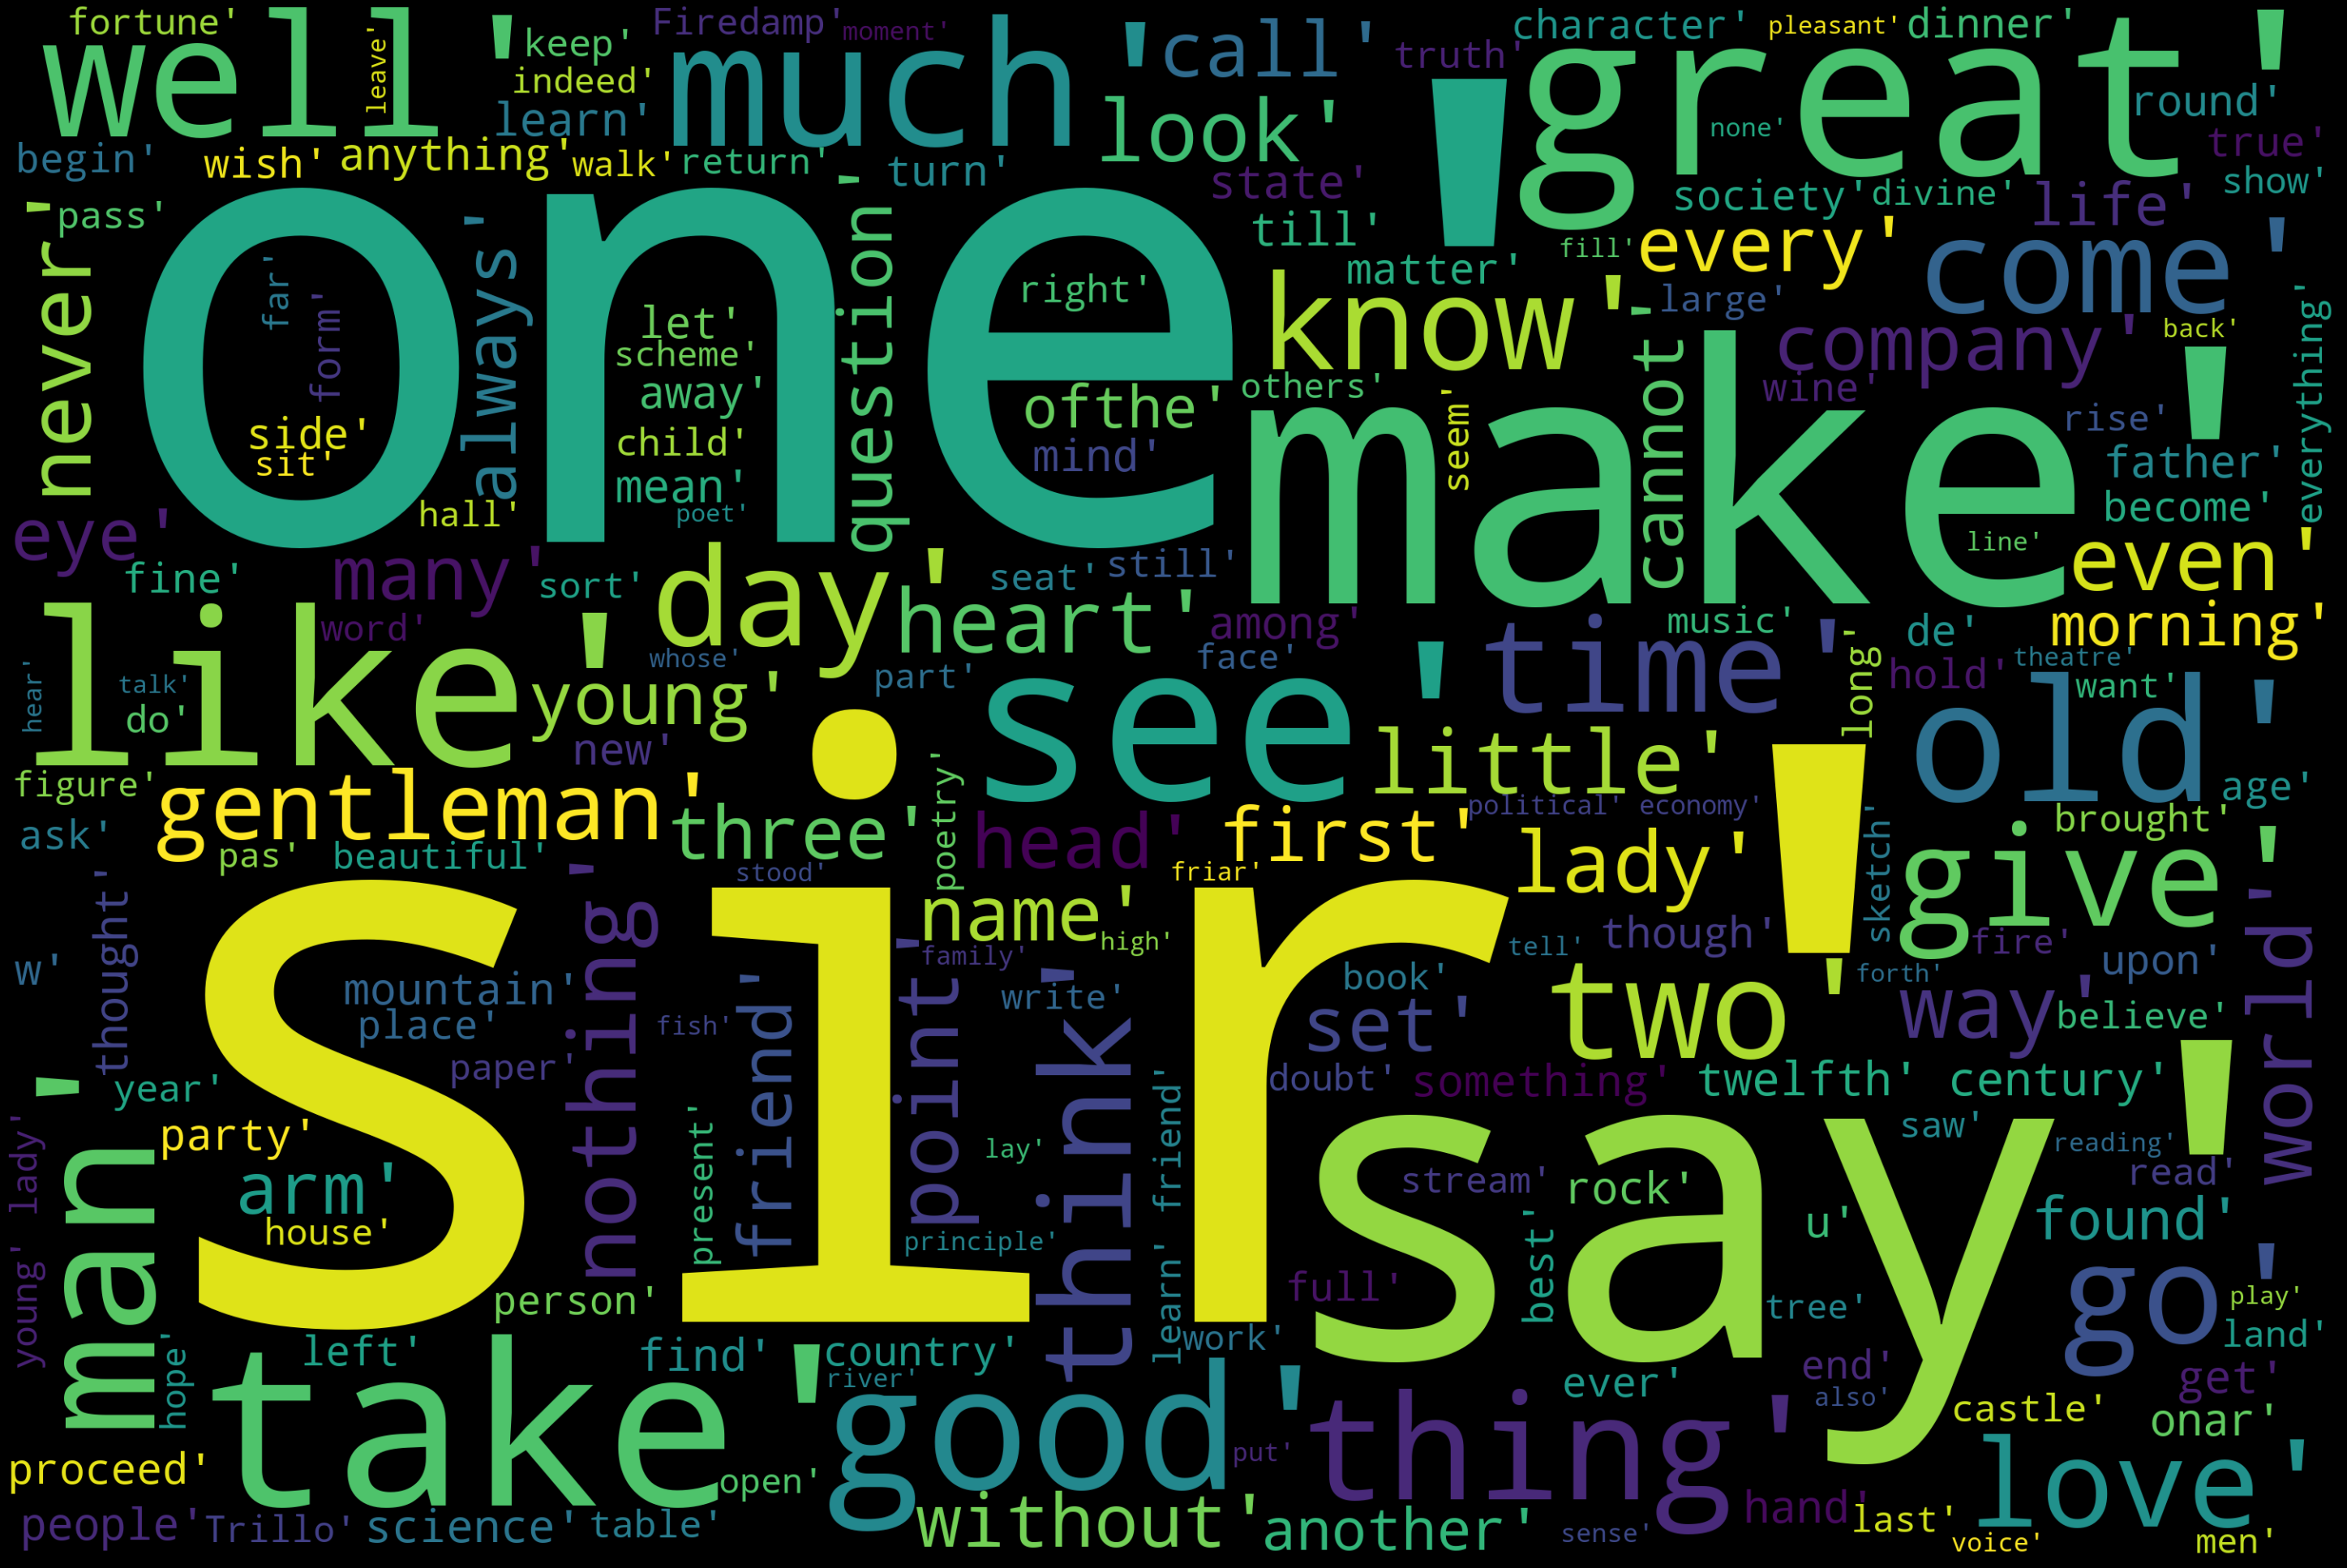

In [6]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate(str(BOOK_1830_EX_2v8))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [18]:
#positive-negative-neutral sentiment analysis
df_book1_words = pd.DataFrame(BOOK_2000_EX_1v8, columns=['word'])
df_book1_words['length'] = df_book1_words.word.str.len()
df_book1_words['book_name'] = 'Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay'
df_book1_words['year'] = 2000
df_book2_words = pd.DataFrame(BOOK_1830_EX_2v8, columns=['word'])
df_book2_words['length'] = df_book2_words.word.str.len()
df_book2_words['book_name'] = 'Crotchet_Castle_by_Thomas_Love_Peacock'
df_book2_words['year'] = 1830
df_book3_words = pd.DataFrame(BOOK_1830_EX_1v8, columns=['word'])
df_book3_words['length'] = df_book3_words.word.str.len()
df_book3_words['book_name'] = 'Paul_Clifford_by_Edward_Bulwer-Lytton'
df_book3_words['year'] = 1830
df_book4_words = pd.DataFrame(BOOK_2000_EX_2v8, columns=['word'])
df_book4_words['length'] = df_book4_words.word.str.len()
df_book4_words['book_name'] = 'jonathan_franzen_the_corrections'
df_book4_words['year'] = 2000

df_all_books_words = pd.concat([df_book1_words, df_book2_words, df_book3_words, df_book4_words])

x = []
for item in df_all_books_words.word.to_list():
  x.append(analyser.polarity_scores(item)['compound'])
df_all_books_words['Sentiment'] = x
df_all_books_words['FinalSentiment'] = ['Positive' if x>0 else 'Negative' if x<0 else 'Neutral'  for x in df_all_books_words['Sentiment'].values]
print(f'Book1 (2000s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Positive") & (df_all_books_words.book_name == "Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay")].count()/df_all_books_words.word.loc[df_all_books_words.book_name == "Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay"].count()*100,1)}% positive words')
print(f'Book2 (1830s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Positive") & (df_all_books_words.book_name == "Crotchet_Castle_by_Thomas_Love_Peacock")].count()/df_all_books_words.word.loc[df_all_books_words.book_name == "Crotchet_Castle_by_Thomas_Love_Peacock"].count()*100,1)}% positive words')
print(f'Book3 (1830s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Positive") & (df_all_books_words.book_name == "Paul_Clifford_by_Edward_Bulwer-Lytton")].count()/df_all_books_words.word.loc[df_all_books_words.book_name == "Paul_Clifford_by_Edward_Bulwer-Lytton"].count()*100,1)}% positive words')
print(f'Book4 (2000s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Positive") & (df_all_books_words.book_name == "jonathan_franzen_the_corrections")].count()/df_all_books_words.word.loc[df_all_books_words.book_name == "jonathan_franzen_the_corrections"].count()*100,1)}% positive words')
print(f'Books (2000s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Positive") & (df_all_books_words.year == 2000)].count()/df_all_books_words.word.loc[df_all_books_words.year == 2000].count()*100,1)}% positive words')
print(f'Books (1830s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Positive") & (df_all_books_words.year == 1830)].count()/df_all_books_words.word.loc[df_all_books_words.year == 1830].count()*100,1)}% positive words')
print(f'Book1 (2000s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Negative") & (df_all_books_words.book_name == "Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay")].count()/df_all_books_words.word.loc[df_all_books_words.book_name == "Chabon_Michael_The Amazing_Adventures_of_Kavalier_Clay"].count()*100,1)}% negative words')
print(f'Book2 (1830s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Negative") & (df_all_books_words.book_name == "Crotchet_Castle_by_Thomas_Love_Peacock")].count()/df_all_books_words.word.loc[df_all_books_words.book_name == "Crotchet_Castle_by_Thomas_Love_Peacock"].count()*100,1)}% negative words')
print(f'Book3 (1830s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Negative") & (df_all_books_words.book_name == "Paul_Clifford_by_Edward_Bulwer-Lytton")].count()/df_all_books_words.word.loc[df_all_books_words.book_name == "Paul_Clifford_by_Edward_Bulwer-Lytton"].count()*100,1)}% negative words')
print(f'Book4 (2000s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Negative") & (df_all_books_words.book_name == "jonathan_franzen_the_corrections")].count()/df_all_books_words.word.loc[df_all_books_words.book_name == "jonathan_franzen_the_corrections"].count()*100,1)}% negative words')
print(f'Books (2000s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Negative") & (df_all_books_words.year == 2000)].count()/df_all_books_words.word.loc[df_all_books_words.year == 2000].count()*100,1)}% negative words')
print(f'Books (1830s) has {round(df_all_books_words.word.loc[(df_all_books_words.FinalSentiment == "Negative") & (df_all_books_words.year == 1830)].count()/df_all_books_words.word.loc[df_all_books_words.year == 1830].count()*100,1)}% negative words')


Book1 (2000s) has 7.5% positive words
Book2 (1830s) has 9.4% positive words
Book3 (1830s) has 10.7% positive words
Book4 (2000s) has 8.6% positive words
Books (2000s) has 7.7% positive words
Books (1830s) has 10.5% positive words
Book1 (2000s) has 5.6% negative words
Book2 (1830s) has 3.6% negative words
Book3 (1830s) has 6.0% negative words
Book4 (2000s) has 5.9% negative words
Books (2000s) has 5.7% negative words
Books (1830s) has 5.6% negative words
